In [1]:
# Step 0: Set Global Seed for Reproducibility
import random
import numpy as np
import torch

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)


In [2]:
# Step 1: Install essential libraries for training, evaluation, and model analysis
!pip install torch torchvision
!pip install timm transformers roboflow pycocotools
!pip install grad-cam torchinfo


In [3]:
# Step 2: Connect to Roboflow and download the COCO-format segmentation dataset
from roboflow import Roboflow
import os
import json

rf = Roboflow(api_key="Mvt9FCxE4mY6vBy5OG08")  # Replace with your key if needed
project = rf.workspace("urban-lake-wastef").project("another_approach_try")
version = project.version(4)
dataset = version.download("coco-segmentation")

# Set paths to the annotation file and images
DATA_ROOT = dataset.location
TRAIN_JSON = os.path.join(DATA_ROOT, 'train', '_annotations.coco.json')
IMG_DIR = os.path.join(DATA_ROOT, 'train')

# Define output directories
REGION_ROOT = '/content/extracted_regions'
SPLIT_ROOT = '/content/split_regions'
os.makedirs(REGION_ROOT, exist_ok=True)


loading Roboflow workspace...
loading Roboflow project...


In [4]:
# Step 3: Extract foreground objects from COCO masks and save cropped images

from PIL import Image, ImageDraw
import numpy as np

# Load COCO annotation JSON
with open(TRAIN_JSON) as f:
    ann_data = json.load(f)

# Create a mapping from category ID to name
cat_map = {c['id']: c['name'] for c in ann_data['categories']}

# Iterate over all annotations to extract and save cropped object regions
for ann in ann_data['annotations']:
    img_info = next(img for img in ann_data['images'] if img['id'] == ann['image_id'])
    img_path = os.path.join(IMG_DIR, img_info['file_name'])
    img = Image.open(img_path).convert('RGB')

    seg = ann['segmentation']
    mask = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)

    for poly in seg:
        pts = np.array(poly).reshape(-1, 2)
        m = Image.new('L', (img_info['width'], img_info['height']), 0)
        ImageDraw.Draw(m).polygon([tuple(p) for p in pts], outline=1, fill=1)
        mask = np.maximum(mask, np.array(m))

    if mask.sum() < 100:  # Skip very small masks
        continue

    region = np.array(img) * mask[:, :, None]
    region_img = Image.fromarray(region)

    label = cat_map[ann['category_id']]
    out_dir = os.path.join(REGION_ROOT, label)
    os.makedirs(out_dir, exist_ok=True)
    base = os.path.splitext(img_info['file_name'])[0]
    out_path = os.path.join(out_dir, f"{base}_{ann['id']}.png")
    region_img.save(out_path)



🔍 Showing 10 Train Set images: original vs masked


Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from current font.
Glyph 128196 (\N{PAGE FACING UP}) missing from current font.
Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from current font.
Glyph 128196 (\N{PAGE FACING UP}) missing from current font.


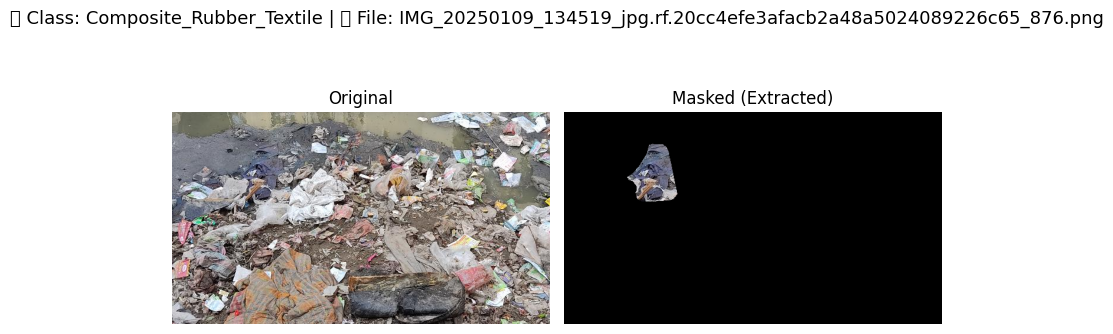

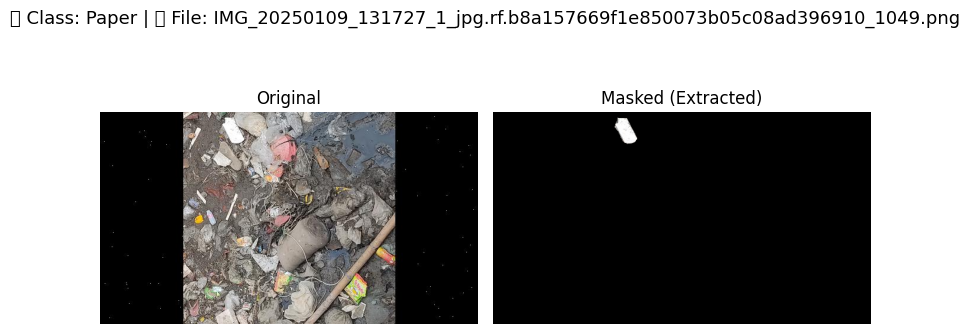

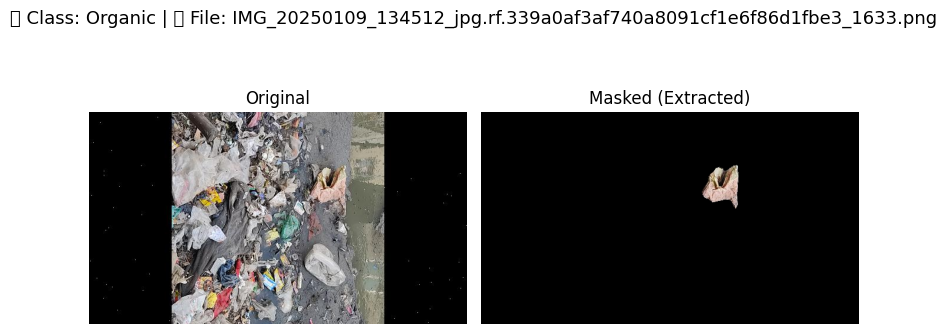

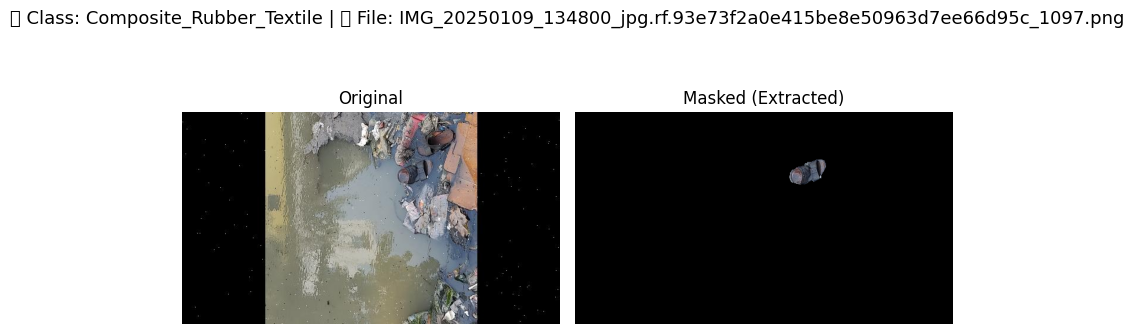

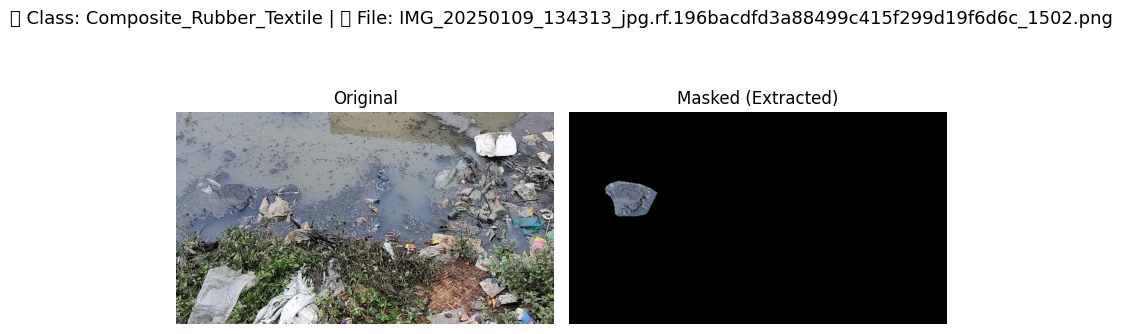

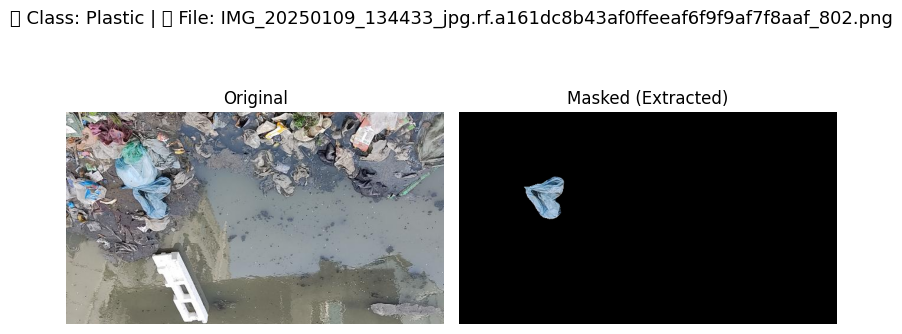

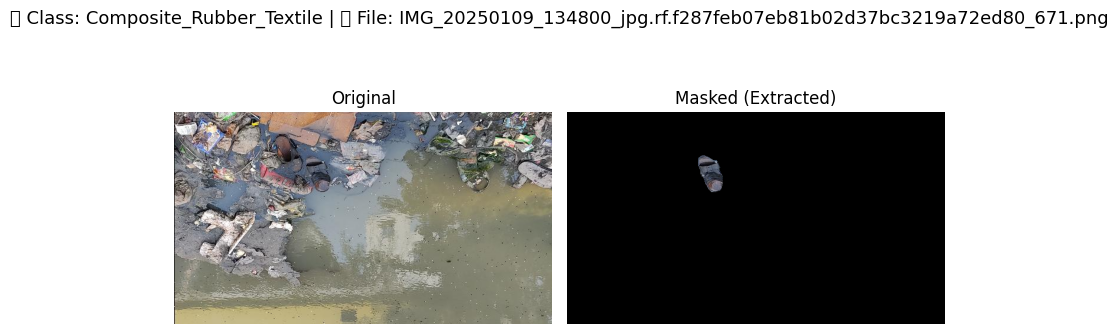

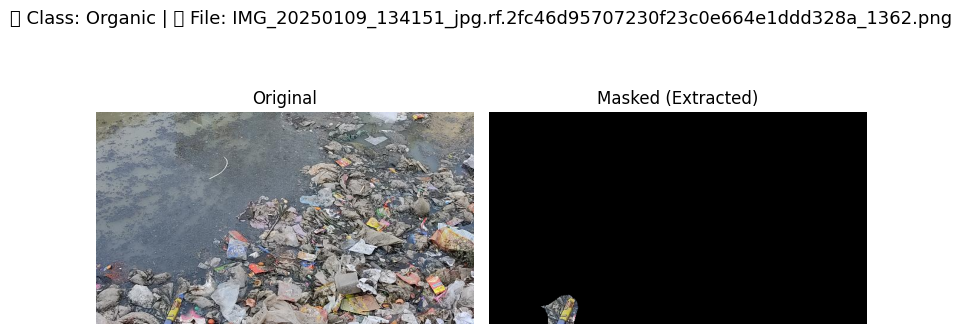

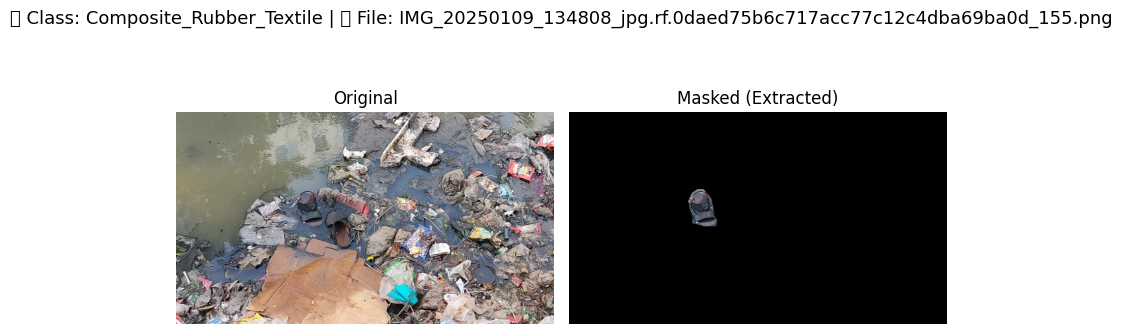

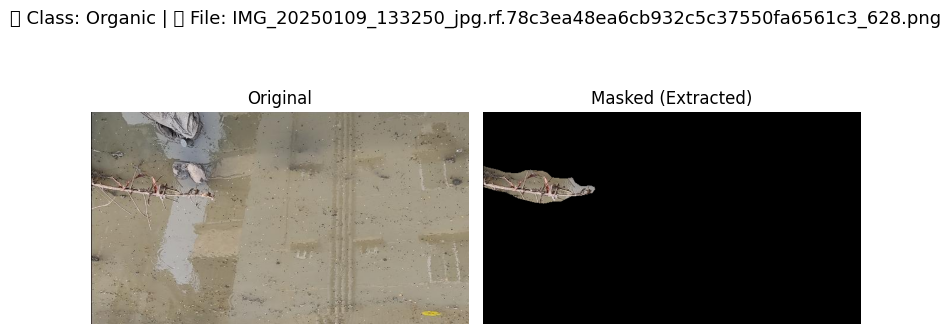

In [5]:
# Step 4: Visualize 10 original vs masked (extracted) regions – before training

import matplotlib.pyplot as plt
from PIL import Image
import os
import random

def show_before_after_masked(original_dir, masked_dir, split_name, num_samples=10):
    """
    Displays side-by-side original vs masked images from a dataset split.
    """
    print(f"\n🔍 Showing {num_samples} {split_name} images: original vs masked")

    classes = sorted(os.listdir(masked_dir))
    selected_images = []

    while len(selected_images) < num_samples:
        chosen_class = random.choice(classes)
        class_mask_dir = os.path.join(masked_dir, chosen_class)
        if not os.path.isdir(class_mask_dir):
            continue
        mask_files = os.listdir(class_mask_dir)
        if not mask_files:
            continue

        chosen_file = random.choice(mask_files)
        selected_images.append((chosen_class, chosen_file))

    for class_name, file_name in selected_images:
        masked_path = os.path.join(masked_dir, class_name, file_name)

        # Extract original filename base
        original_basename_base = "_".join(file_name.split("_")[:-1])
        possible_exts = [".jpg", ".png"]
        original_path = None

        for ext in possible_exts:
            candidate = os.path.join(original_dir, original_basename_base + ext)
            if os.path.exists(candidate):
                original_path = candidate
                break

        if not original_path:
            print(f"⚠️ Original not found for: {original_basename_base}")
            continue

        original_img = Image.open(original_path).convert("RGB")
        masked_img = Image.open(masked_path).convert("RGB")

        fig, axs = plt.subplots(1, 2, figsize=(8, 4))
        axs[0].imshow(original_img)
        axs[0].set_title("Original")
        axs[0].axis("off")

        axs[1].imshow(masked_img)
        axs[1].set_title("Masked (Extracted)")
        axs[1].axis("off")

        fig.suptitle(f"🟢 Class: {class_name} | 📄 File: {file_name}", fontsize=13)
        plt.tight_layout()
        plt.show()

# ✅ Call this after Step 3
show_before_after_masked(
    original_dir=os.path.join(DATA_ROOT, "train"),
    masked_dir="/content/extracted_regions",
    split_name="Train Set"
)

In [6]:
# Step 4.5: Split dataset into 60% train, 20% val, 20% test

import shutil
from sklearn.model_selection import train_test_split

# Create split folders
for split in ['train', 'val', 'test']:
    os.makedirs(os.path.join(SPLIT_ROOT, split), exist_ok=True)

# For each class, split its images into train/val/test
for class_name in os.listdir(REGION_ROOT):
    class_path = os.path.join(REGION_ROOT, class_name)
    if not os.path.isdir(class_path):
        continue

    files = os.listdir(class_path)
    train_files, temp_files = train_test_split(files, test_size=0.4, random_state=42)
    val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)

    for split, split_files in zip(['train', 'val', 'test'], [train_files, val_files, test_files]):
        split_class_dir = os.path.join(SPLIT_ROOT, split, class_name)
        os.makedirs(split_class_dir, exist_ok=True)
        for f in split_files:
            shutil.copy2(os.path.join(class_path, f), os.path.join(split_class_dir, f))


In [7]:
# Step 5: Define a PyTorch Dataset class with augmentation and weighted sampling

from torch.utils.data import Dataset, WeightedRandomSampler
from torchvision import transforms
from collections import defaultdict
from PIL import Image

class WasteRegionDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.samples = []
        self.transform = transform or transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(10),
            transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.03),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        self.label2id = {}
        class_counts = defaultdict(int)

        # Collect all image paths and assign class indices
        classes = sorted(os.listdir(root_dir))
        self.label2id = {c: i for i, c in enumerate(classes)}

        for c in classes:
            class_dir = os.path.join(root_dir, c)
            for f in os.listdir(class_dir):
                self.samples.append((os.path.join(class_dir, f), self.label2id[c]))
                class_counts[self.label2id[c]] += 1

        # Compute sample weights for balancing
        self.sample_weights = [1.0 / class_counts[label] for _, label in self.samples]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert('RGB')
        img = self.transform(img)
        return img, label


In [8]:
# Step 6: Set device (GPU or CPU) and define paths to the dataset splits
from timm import create_model

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Define the root directories for each data split
TRAIN_DIR = os.path.join(SPLIT_ROOT, 'train')
VAL_DIR   = os.path.join(SPLIT_ROOT, 'val')
TEST_DIR  = os.path.join(SPLIT_ROOT, 'test')

# Determine the number of classes from folder names in train set
num_classes = len(os.listdir(TRAIN_DIR))


In [9]:
# Step 7: Initialize datasets and DataLoaders with augmentation and weighted sampling for training

# Create dataset instances
train_ds = WasteRegionDataset(TRAIN_DIR)
val_ds   = WasteRegionDataset(VAL_DIR, transform=train_ds.transform)
test_ds  = WasteRegionDataset(TEST_DIR, transform=val_ds.transform)

from torch.utils.data import DataLoader, WeightedRandomSampler

# Apply WeightedRandomSampler to address class imbalance in training data
train_sampler = WeightedRandomSampler(train_ds.sample_weights, len(train_ds.sample_weights), replacement=True)

# Create DataLoaders
train_loader = DataLoader(train_ds, batch_size=16, sampler=train_sampler)
val_loader   = DataLoader(val_ds, batch_size=16, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=16, shuffle=False)


In [10]:
# Step 8: Define training function with mixup, label smoothing, early stopping, weighted loss, and checkpoint saving
from sklearn.utils.class_weight import compute_class_weight
from transformers import get_cosine_schedule_with_warmup
from torch.cuda.amp import GradScaler
import torch.nn as nn

def train_one_model(model_name, use_mixup=True, label_smooth=0.1, seed=42, patience=15, save_as=None):
    set_seed(seed)
    model = create_model(model_name, pretrained=True, num_classes=num_classes).to(device)

    labels = [label for _, label in train_ds.samples]
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
    class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

    criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=label_smooth)
    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-3)
    scheduler = get_cosine_schedule_with_warmup(
        optimizer, num_warmup_steps=3 * len(train_loader),
        num_training_steps=len(train_loader) * 100
    )
    scaler = GradScaler()

    def mixup_data(x, y, alpha=0.4):
        lam = np.random.beta(alpha, alpha)
        index = torch.randperm(x.size(0)).to(x.device)
        mixed_x = lam * x + (1 - lam) * x[index]
        y_a, y_b = y, y[index]
        return mixed_x, y_a, y_b, lam

    def mixup_criterion(criterion, pred, y_a, y_b, lam):
        return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

    history = {'train_loss': [], 'val_loss': [], 'val_acc': [], 'train_acc': []}
    best_val_loss = float('inf')
    no_improve_epochs = 0
    save_path = f"{save_as}_best.pth" if save_as else f"{model_name}_best.pth"

    for epoch in range(2):
        model.train()
        total_loss = 0
        train_correct = train_total = 0

        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()

            if use_mixup:
                imgs, y_a, y_b, lam = mixup_data(imgs, labels)
            else:
                y_a, y_b, lam = labels, labels, 1.0

            with torch.cuda.amp.autocast():
                outputs = model(imgs)
                loss = mixup_criterion(criterion, outputs, y_a, y_b, lam) if use_mixup else criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            total_loss += loss.item()

            # Calculate training accuracy (only for non-mixup, for mixup it's not meaningful)
            if not use_mixup:
                preds = outputs.argmax(dim=1)
                train_correct += (preds == labels).sum().item()
                train_total += labels.size(0)

        scheduler.step()
        avg_train_loss = total_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)

        # Compute training accuracy for this epoch
        if not use_mixup:
            train_acc = train_correct / train_total if train_total > 0 else 0.0
        else:
            train_acc = None  # Or np.nan

        history['train_acc'].append(train_acc)

        model.eval()
        val_loss = 0
        correct = total = 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                val_loss += criterion(outputs, labels).item()
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        avg_val_loss = val_loss / len(val_loader)
        val_acc = correct / total
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_acc)

        print(f"[{model_name}] Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | "
              f"Val Loss: {avg_val_loss:.4f} | "
              f"Val Acc: {val_acc:.4f}" +
              (f" | Train Acc: {train_acc:.4f}" if train_acc is not None else ""))

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            no_improve_epochs = 0
            torch.save(model.state_dict(), save_path)
            print("🔸 New best model saved.")
        else:
            no_improve_epochs += 1
            if no_improve_epochs >= patience:
                print("🛑 Early stopping triggered.")
                break

    return model, history

In [11]:
# Step 9: Train multiple configurations of model and save each model uniquely
import csv

model_list = ['convnext_tiny']
seeds = [42, 123, 777]
mixup_options = [True, False]
label_smoothings = [0.1, 0.0]

all_histories = {}

with open("ablation_results.csv", "w", newline='') as f:
    writer = csv.writer(f)
    writer.writerow(["Model", "Seed", "Mixup", "Label Smoothing", "Val Accuracy", "Checkpoint"])

    for model_name in model_list:
        for mixup in mixup_options:
            for smooth in label_smoothings:
                for seed in seeds:
                    run_id = f"{model_name}_mixup{mixup}_smooth{smooth}_seed{seed}"
                    print(f"🔁 Training: {run_id}")

                    model, history = train_one_model(
                        model_name=model_name,
                        use_mixup=mixup,
                        label_smooth=smooth,
                        seed=seed,
                        patience=15,
                        save_as=run_id
                    )

                    final_val_acc = history['val_acc'][-1]
                    writer.writerow([model_name, seed, mixup, smooth, final_val_acc, f"{run_id}_best.pth"])
                    all_histories[run_id] = history


🔁 Training: convnext_tiny_mixupTrue_smooth0.1_seed42


`torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


[convnext_tiny] Epoch 1 | Train Loss: 1.5767 | Val Loss: 1.6514 | Val Acc: 0.1857
🔸 New best model saved.
[convnext_tiny] Epoch 2 | Train Loss: 1.5098 | Val Loss: 1.6803 | Val Acc: 0.1899
🔁 Training: convnext_tiny_mixupTrue_smooth0.1_seed123


`torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


[convnext_tiny] Epoch 1 | Train Loss: 1.6225 | Val Loss: 1.6109 | Val Acc: 0.2131
🔸 New best model saved.
[convnext_tiny] Epoch 2 | Train Loss: 1.4970 | Val Loss: 1.6475 | Val Acc: 0.2089
🔁 Training: convnext_tiny_mixupTrue_smooth0.1_seed777


`torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


[convnext_tiny] Epoch 1 | Train Loss: 1.5952 | Val Loss: 1.8045 | Val Acc: 0.2236
🔸 New best model saved.
[convnext_tiny] Epoch 2 | Train Loss: 1.4677 | Val Loss: 1.7425 | Val Acc: 0.2321
🔸 New best model saved.
🔁 Training: convnext_tiny_mixupTrue_smooth0.0_seed42


`torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


[convnext_tiny] Epoch 1 | Train Loss: 1.5824 | Val Loss: 1.5954 | Val Acc: 0.1857
🔸 New best model saved.
[convnext_tiny] Epoch 2 | Train Loss: 1.5165 | Val Loss: 1.6312 | Val Acc: 0.1899
🔁 Training: convnext_tiny_mixupTrue_smooth0.0_seed123


`torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


[convnext_tiny] Epoch 1 | Train Loss: 1.6284 | Val Loss: 1.5384 | Val Acc: 0.2131
🔸 New best model saved.
[convnext_tiny] Epoch 2 | Train Loss: 1.4961 | Val Loss: 1.5893 | Val Acc: 0.2068
🔁 Training: convnext_tiny_mixupTrue_smooth0.0_seed777


`torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


[convnext_tiny] Epoch 1 | Train Loss: 1.5857 | Val Loss: 1.7329 | Val Acc: 0.2236
🔸 New best model saved.
[convnext_tiny] Epoch 2 | Train Loss: 1.4585 | Val Loss: 1.6864 | Val Acc: 0.2321
🔸 New best model saved.
🔁 Training: convnext_tiny_mixupFalse_smooth0.1_seed42


`torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


[convnext_tiny] Epoch 1 | Train Loss: 1.5790 | Val Loss: 1.6321 | Val Acc: 0.2152 | Train Acc: 0.2055
🔸 New best model saved.
[convnext_tiny] Epoch 2 | Train Loss: 1.4783 | Val Loss: 1.6605 | Val Acc: 0.1835 | Train Acc: 0.2458
🔁 Training: convnext_tiny_mixupFalse_smooth0.1_seed123


`torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


[convnext_tiny] Epoch 1 | Train Loss: 1.5908 | Val Loss: 1.6189 | Val Acc: 0.2300 | Train Acc: 0.2338
🔸 New best model saved.
[convnext_tiny] Epoch 2 | Train Loss: 1.5101 | Val Loss: 1.6344 | Val Acc: 0.2321 | Train Acc: 0.2528
🔁 Training: convnext_tiny_mixupFalse_smooth0.1_seed777


`torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


[convnext_tiny] Epoch 1 | Train Loss: 1.5957 | Val Loss: 1.7893 | Val Acc: 0.2152 | Train Acc: 0.2867
🔸 New best model saved.
[convnext_tiny] Epoch 2 | Train Loss: 1.4270 | Val Loss: 1.7310 | Val Acc: 0.2426 | Train Acc: 0.3199
🔸 New best model saved.
🔁 Training: convnext_tiny_mixupFalse_smooth0.0_seed42


`torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


[convnext_tiny] Epoch 1 | Train Loss: 1.5858 | Val Loss: 1.5731 | Val Acc: 0.2152 | Train Acc: 0.2055
🔸 New best model saved.
[convnext_tiny] Epoch 2 | Train Loss: 1.4832 | Val Loss: 1.6104 | Val Acc: 0.1835 | Train Acc: 0.2444
🔁 Training: convnext_tiny_mixupFalse_smooth0.0_seed123


`torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


[convnext_tiny] Epoch 1 | Train Loss: 1.5948 | Val Loss: 1.5468 | Val Acc: 0.2300 | Train Acc: 0.2338
🔸 New best model saved.
[convnext_tiny] Epoch 2 | Train Loss: 1.5106 | Val Loss: 1.5734 | Val Acc: 0.2278 | Train Acc: 0.2528
🔁 Training: convnext_tiny_mixupFalse_smooth0.0_seed777


`torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


[convnext_tiny] Epoch 1 | Train Loss: 1.5852 | Val Loss: 1.7153 | Val Acc: 0.2152 | Train Acc: 0.2867
🔸 New best model saved.
[convnext_tiny] Epoch 2 | Train Loss: 1.4142 | Val Loss: 1.6745 | Val Acc: 0.2468 | Train Acc: 0.3178
🔸 New best model saved.


In [12]:
# Step X: Install and import Grad-CAM + helper functions
!pip install -q grad-cam

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from torchvision.transforms.functional import resize
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# List of models that support classic Grad-CAM
GRADCAM_SUPPORTED_MODELS = [
    'efficientnet_b0',
    'resnet34',
    'densenet121',
    'mobilenet_v3_small',
    'convnext_tiny',
    'inception_v3',
    'regnet_y_400mf'
]

# Models that require transformer-specific attention visualization
TRANSFORMER_MODELS = [
    'vit_b_16',
    'swin_t'
]

def get_gradcam_target_layer(model):
    if hasattr(model, "layer4"):
        return [model.layer4[-1]]
    if hasattr(model, "blocks"):
        return [model.blocks[-1]]
    if hasattr(model, "features"):
        return [model.features[-1]]
    if hasattr(model, "stages"):
        return [model.stages[-1][-1]]
    print("❗ Unable to automatically determine target layer.")
    for name, module in model.named_modules():
        print(name)
    raise ValueError("Set target_layers manually.")

def visualize_gradcam_or_attention(img_path, model, transform, model_name, class_id=None):
    model.eval()
    img = Image.open(img_path).convert("RGB")
    input_tensor = transform(img).unsqueeze(0).to(device)
    rgb_img = np.array(resize(img, (224, 224))).astype(np.float32) / 255

    if model_name in GRADCAM_SUPPORTED_MODELS:
        target_layers = get_gradcam_target_layer(model)
        targets = [ClassifierOutputTarget(class_id)] if class_id is not None else None
        with GradCAM(model=model, target_layers=target_layers) as cam:
            grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]
        cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
        plt.imshow(cam_image)
        plt.title("Grad-CAM Visualization")
        plt.axis("off")
        plt.show()
    elif model_name in TRANSFORMER_MODELS:
        # Show Attention Rollout (ViT/Swin) or fallback
        try:
            if hasattr(model, 'blocks'):  # For ViT
                # Get attention weights from last block
                attn = model.blocks[-1].attn.get_attn()  # This line may change based on model implementation
                attn_map = attn[0].mean(0).detach().cpu().numpy()
                attn_map = attn_map[0, 1:].reshape(14, 14)  # Assuming patch size 16 for 224x224
                attn_map = cv2.resize(attn_map, (224, 224))
                plt.imshow(rgb_img)
                plt.imshow(attn_map, cmap='jet', alpha=0.4)
                plt.title("Attention Map Overlay (ViT)")
                plt.axis("off")
                plt.show()
            elif hasattr(model, 'layers') or hasattr(model, 'stages'):  # For Swin
                print("Attention visualization for Swin is not implemented here. Please use a dedicated Swin transformer visualization tool.")
            else:
                print("Transformer attention visualization not implemented for this model.")
        except Exception as e:
            print(f"⚠️ Attention visualization failed: {e}")
    else:
        print(f"Grad-CAM/Attention visualization not available for model: {model_name}")

In [13]:
# Step 10: Plot training vs validation loss and accuracy to assess learning and overfitting

import matplotlib.pyplot as plt
import numpy as np

def plot_model_histories(all_histories):
    """
    Plots loss and accuracy curves from the training history of each model configuration.
    
    Parameters:
    - all_histories (dict): Dictionary of training histories returned by train_one_model().
                            Keys are run names, values are dicts with 'train_loss', 'val_loss', 'val_acc', 'train_acc'.

    Each model will generate:
    - Train vs Val Loss curve
    - Train vs Val Accuracy curve
    """
    for run_id, hist in all_histories.items():
        epochs = range(1, len(hist['train_loss']) + 1)
        
        plt.figure(figsize=(16, 5))
        
        # Loss Curve
        plt.subplot(1, 2, 1)
        plt.plot(epochs, hist['train_loss'], label='Train Loss', marker='o')
        plt.plot(epochs, hist['val_loss'], label='Val Loss', marker='x')
        plt.title(f"{run_id} – Loss Curve")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True)

        # Accuracy Curve
        plt.subplot(1, 2, 2)
        # Only plot train accuracy if it exists and has at least one non-None value
        if 'train_acc' in hist and any(x is not None for x in hist['train_acc']):
            # Replace None with np.nan for plotting
            train_acc_plot = [x if x is not None else np.nan for x in hist['train_acc']]
            plt.plot(epochs, train_acc_plot, label='Train Accuracy', marker='d', color='blue')
        plt.plot(epochs, hist['val_acc'], label='Val Accuracy', marker='s', color='green')
        plt.title(f"{run_id} – Accuracy Curve")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.grid(True)

        plt.suptitle(f"Training Progress – {run_id}", fontsize=14)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

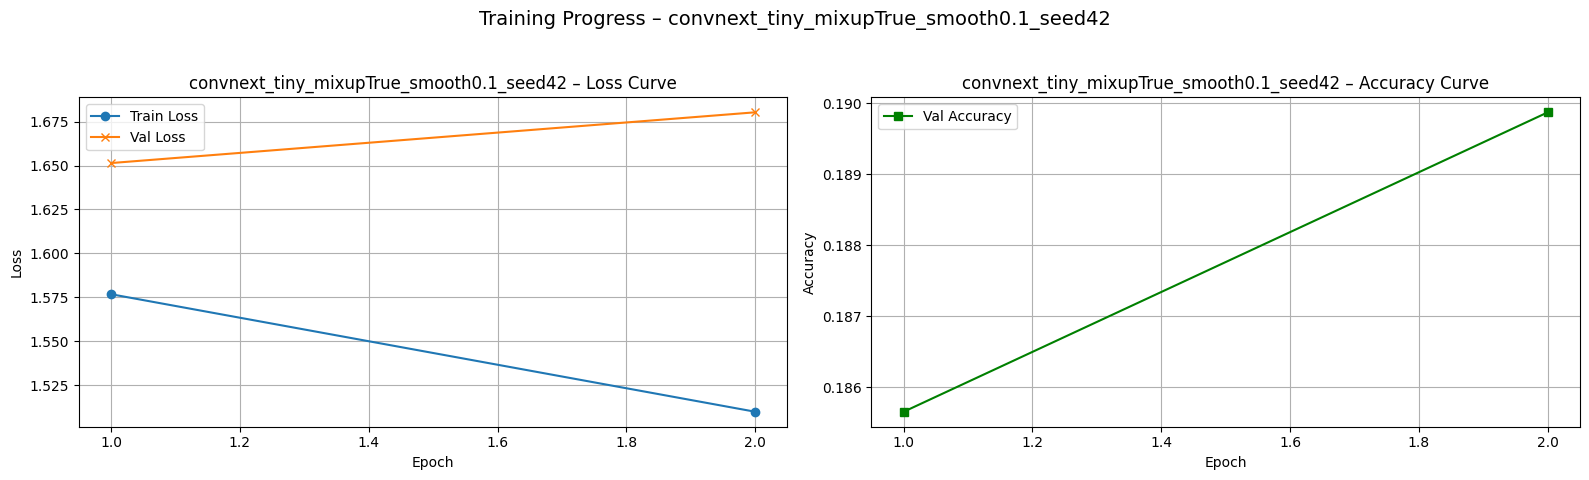

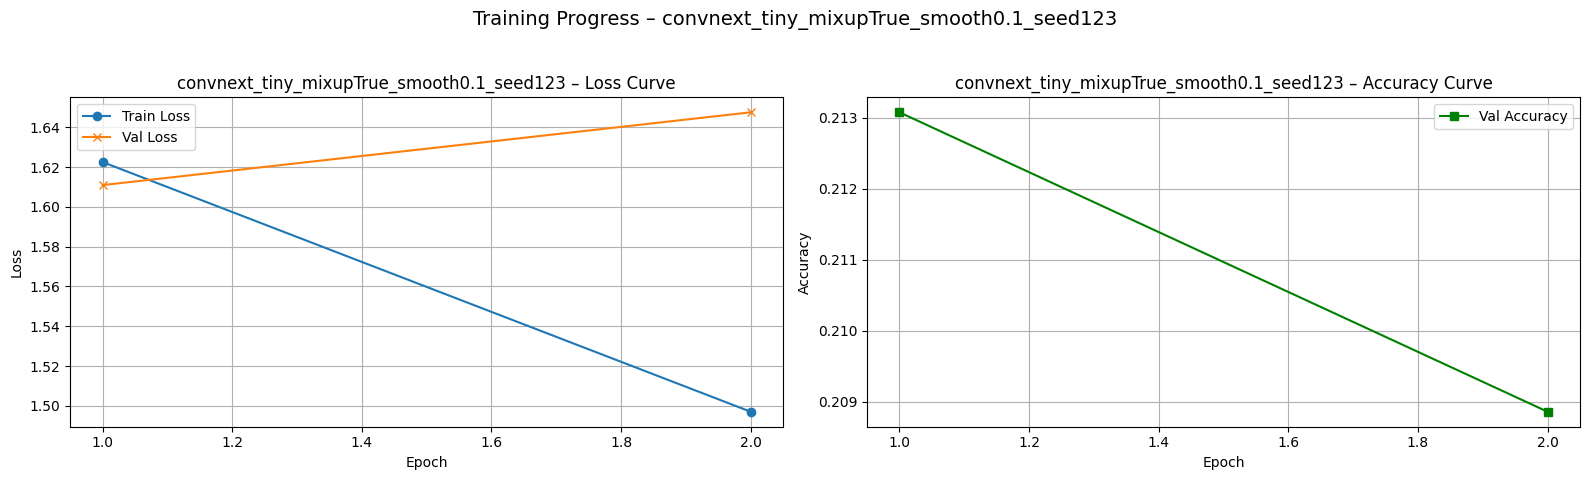

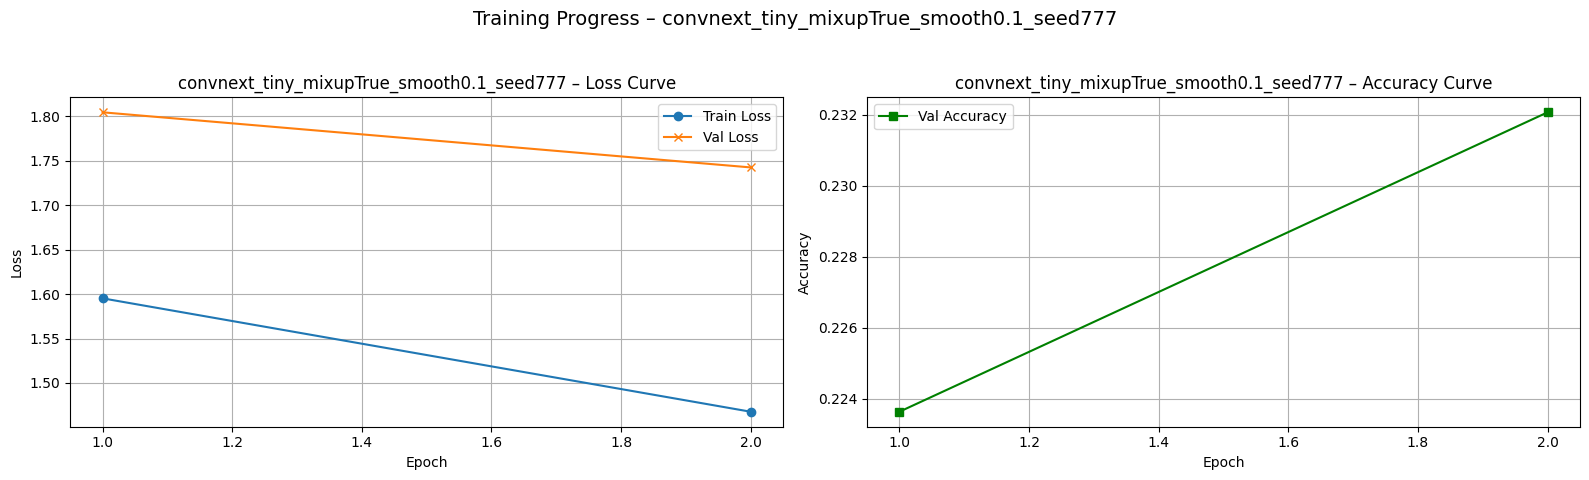

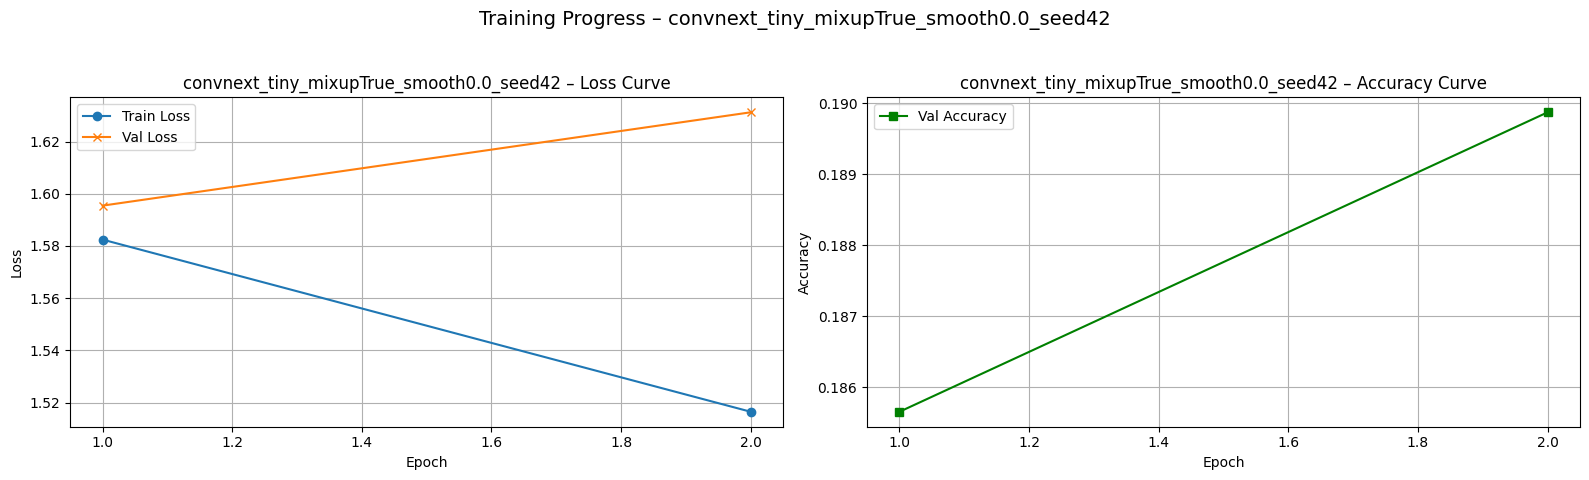

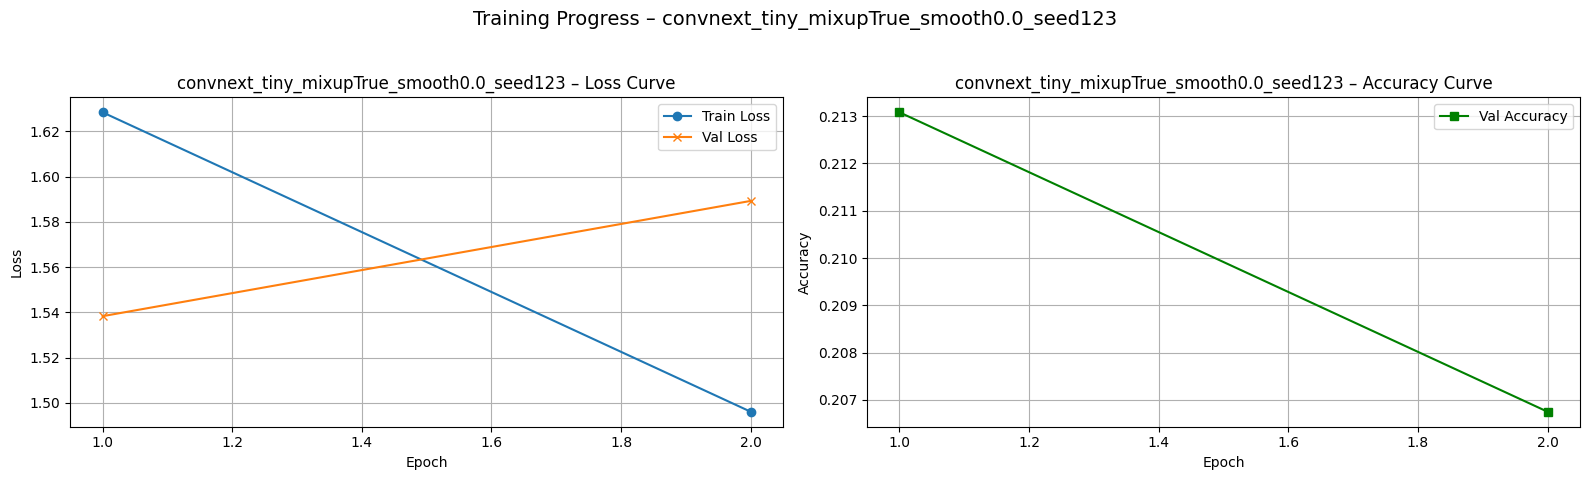

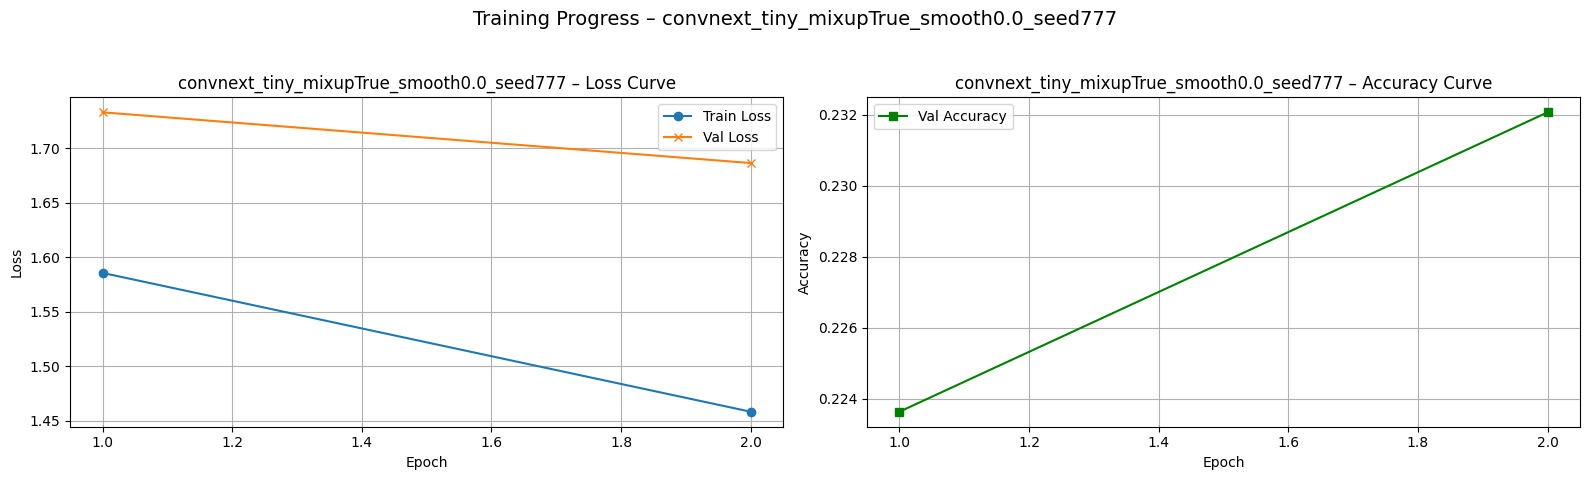

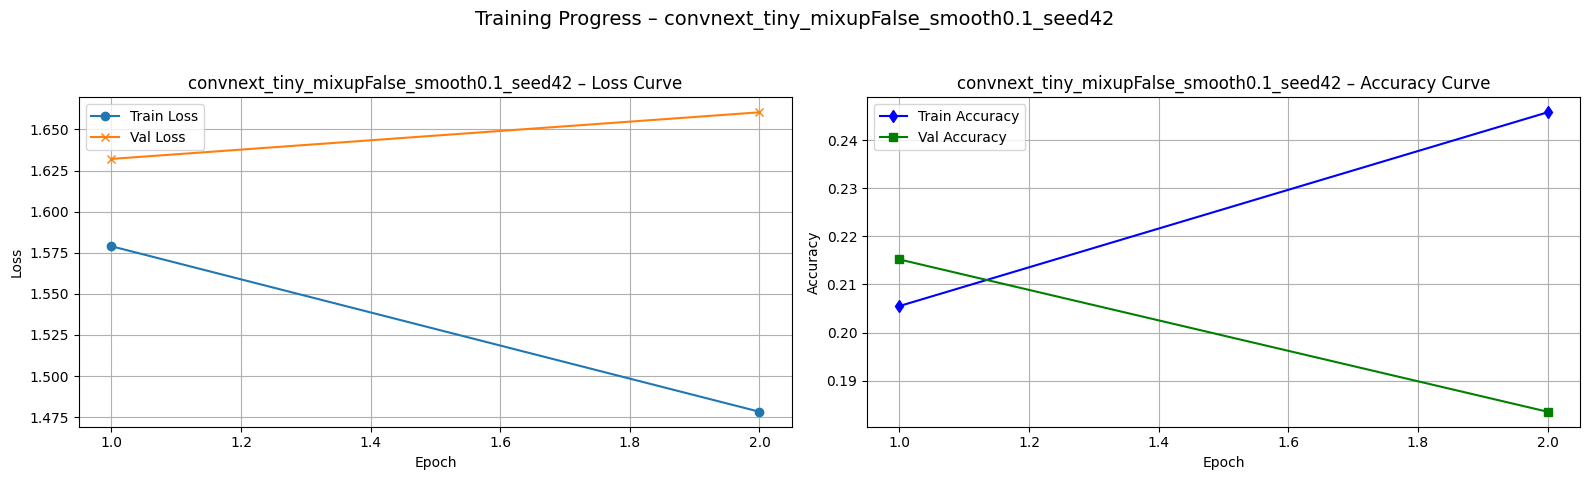

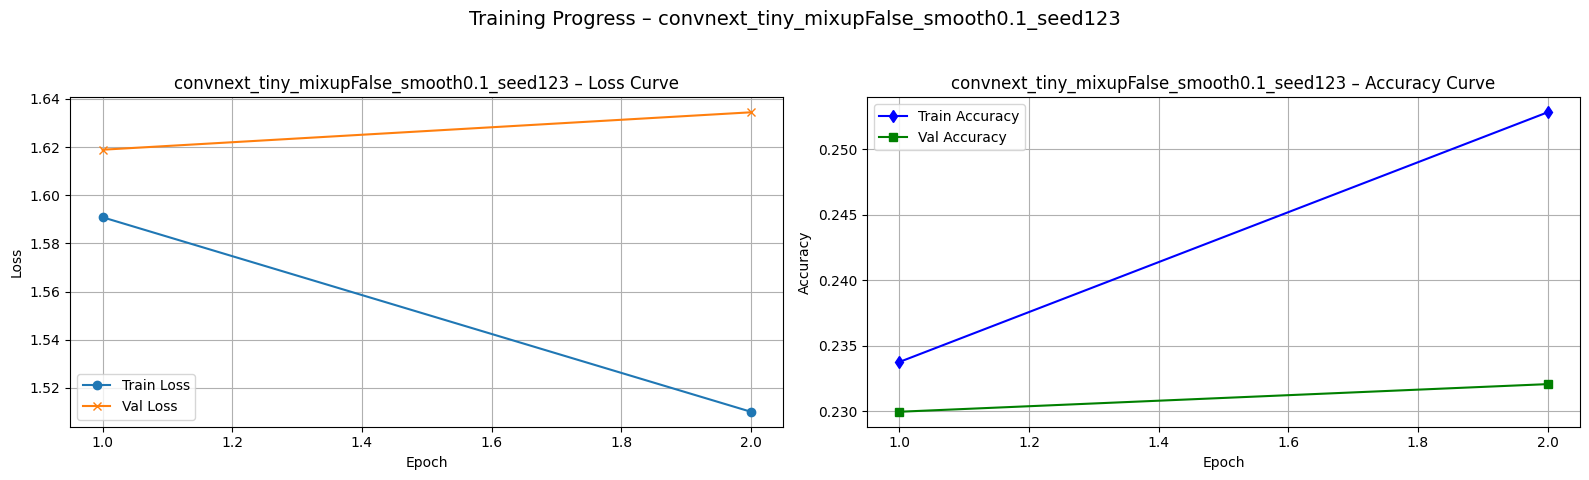

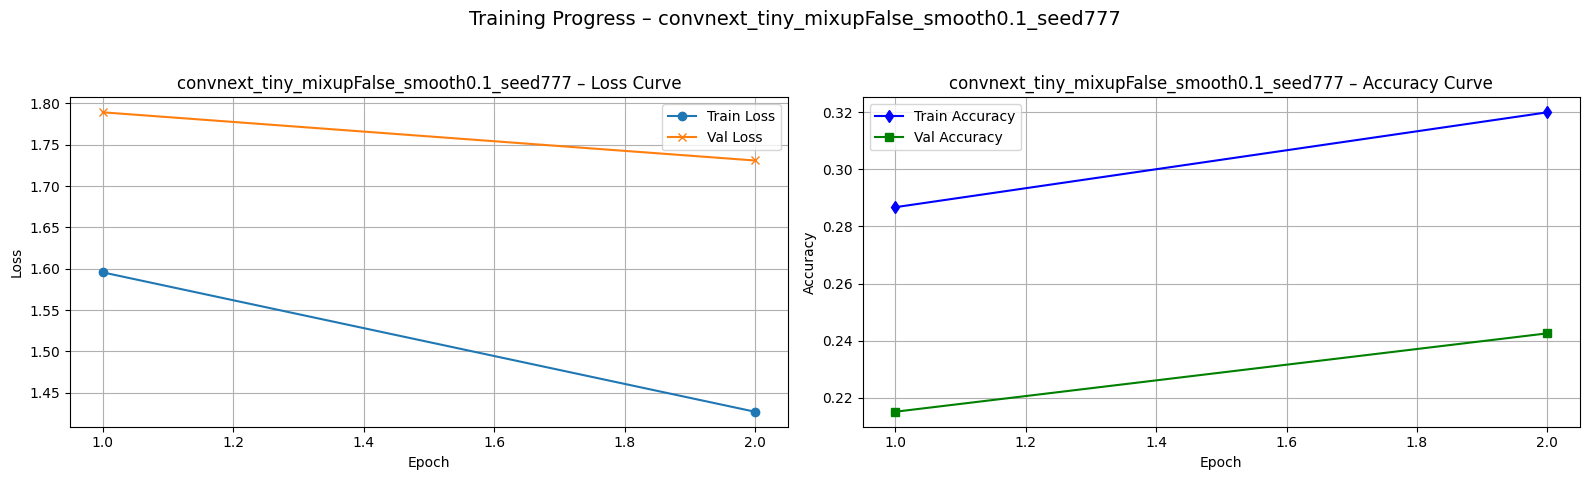

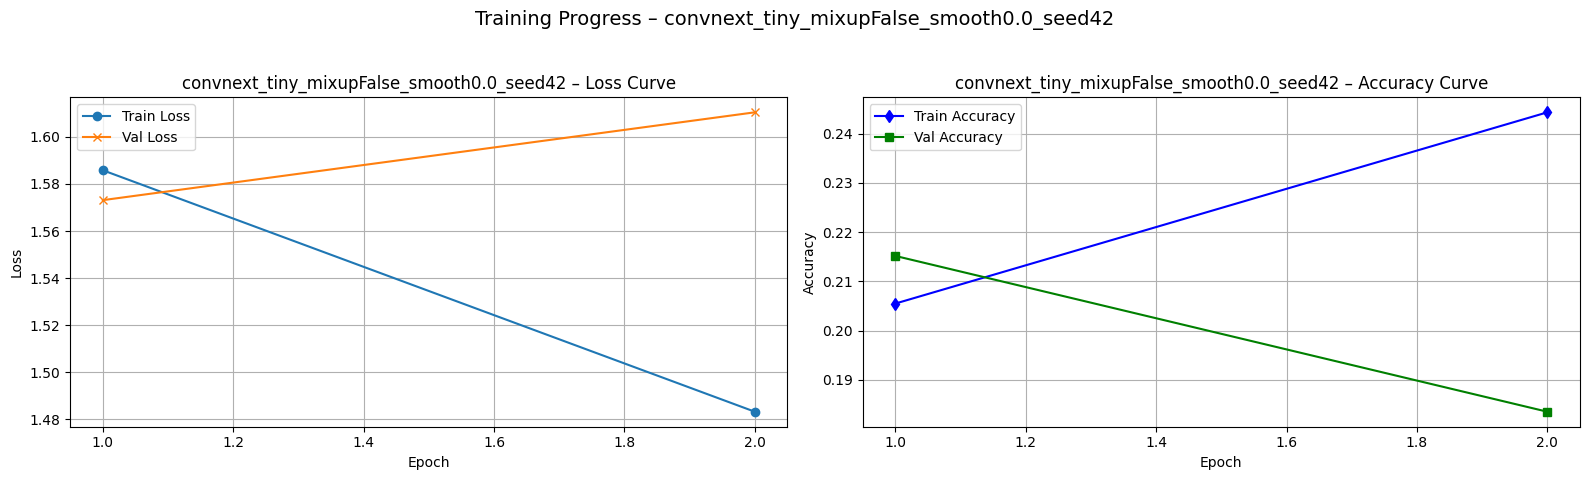

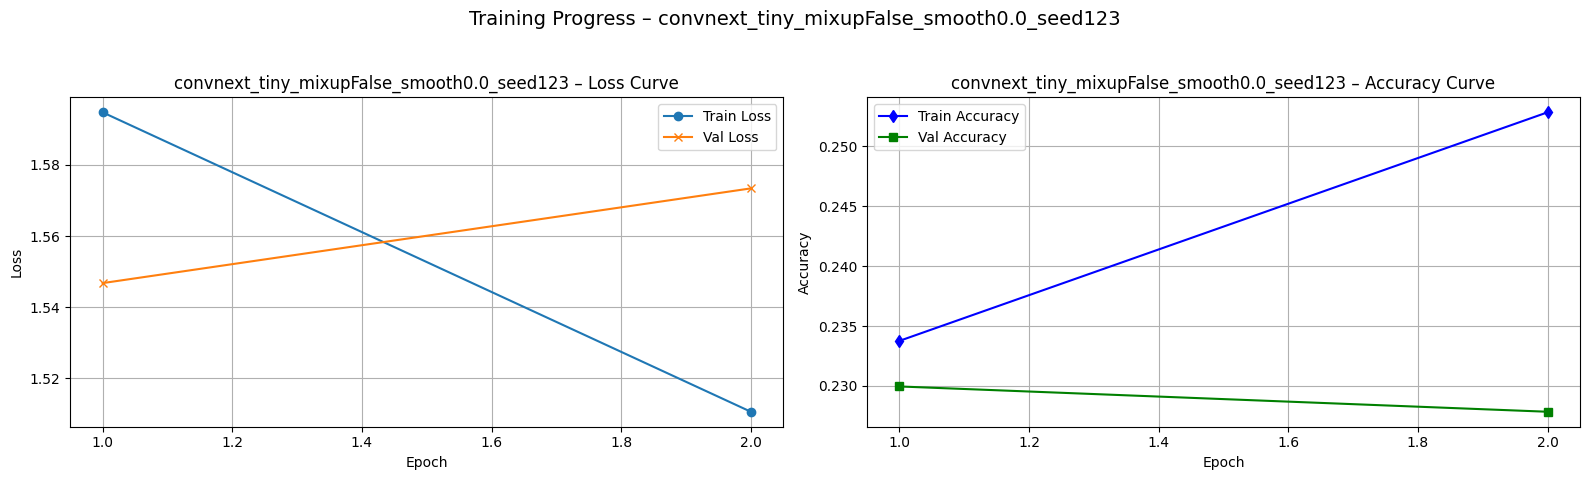

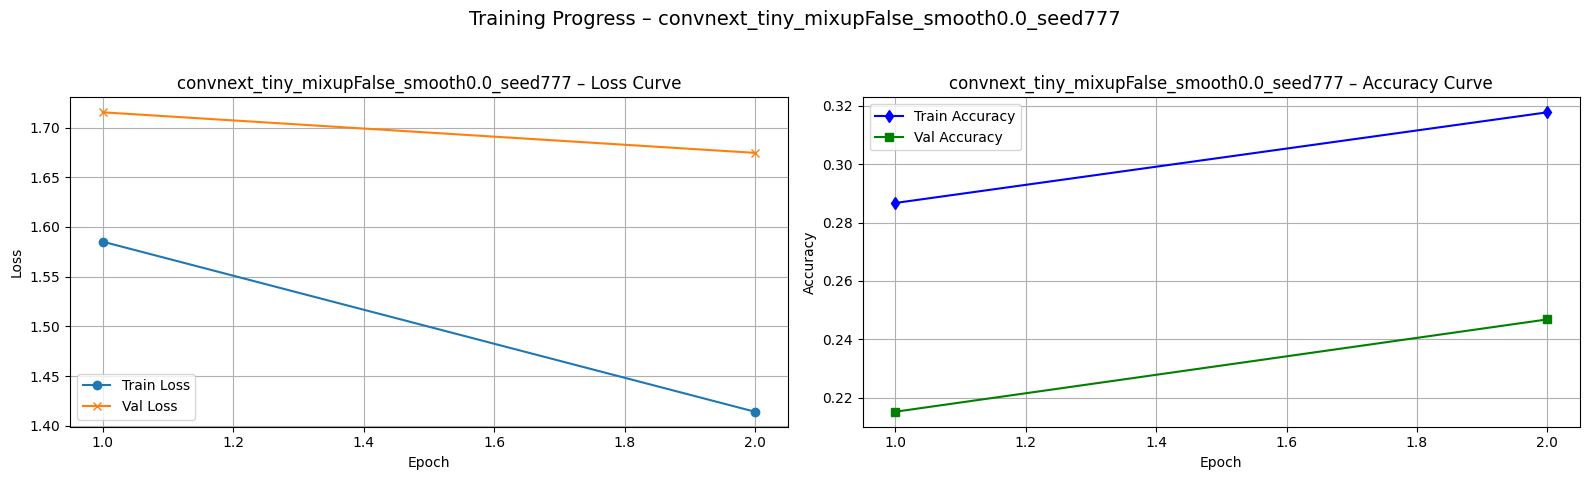

In [14]:
# Step 11: Generate overfitting plots for all trained models using saved training histories
plot_model_histories(all_histories)


In [15]:
# Step 12: Read the CSV results and compute average and std deviation for each model setting
import pandas as pd

df = pd.read_csv("ablation_results.csv")

summary = df.groupby(["Model", "Mixup", "Label Smoothing"])["Val Accuracy"].agg(['mean', 'std']).reset_index()

print("📊 Ablation Results (mean ± std across seeds):")
print(summary)

# 🔍 Select best run
best_row = df.loc[df["Val Accuracy"].idxmax()]
print("\n\n🏆 Best configuration:\\n", best_row)

# Extract values for Step 11
best_checkpoint_path = best_row["Checkpoint"]
best_model_name = best_row["Model"]


📊 Ablation Results (mean ± std across seeds):
           Model  Mixup  Label Smoothing      mean       std
0  convnext_tiny  False              0.0  0.219409  0.032478
1  convnext_tiny  False              0.1  0.219409  0.031505
2  convnext_tiny   True              0.0  0.209564  0.021237
3  convnext_tiny   True              0.1  0.210267  0.021132


🏆 Best configuration:\n Model                                                  convnext_tiny
Seed                                                             777
Mixup                                                          False
Label Smoothing                                                  0.0
Val Accuracy                                                0.246835
Checkpoint         convnext_tiny_mixupFalse_smooth0.0_seed777_bes...
Name: 11, dtype: object


🧪 STEP 13: Evaluating Best Model Configuration on TEST SET
Model Architecture: convnext_tiny
Mixup Enabled:      False
Label Smoothing:    0.0
Random Seed:        777
Validation Accuracy:0.2468
Checkpoint File:    convnext_tiny_mixupFalse_smooth0.0_seed777_best.pth
➡️ Dataset Used:      Held-out TEST SET

🔍 Classification Report (on Test Set):
                          precision    recall  f1-score   support

Composite_Rubber_Textile     0.2946    0.4231    0.3474        78
                 Organic     0.1890    0.2892    0.2286        83
                   Paper     0.2523    0.5657    0.3489        99
                 Plastic     0.3846    0.0234    0.0441       214

                accuracy                         0.2489       474
               macro avg     0.2801    0.3253    0.2422       474
            weighted avg     0.3079    0.2489    0.1899       474

Test Accuracy:  0.2489
Test Precision: 0.3079
Test Recall:    0.2489
Test F1-Score:  0.1899


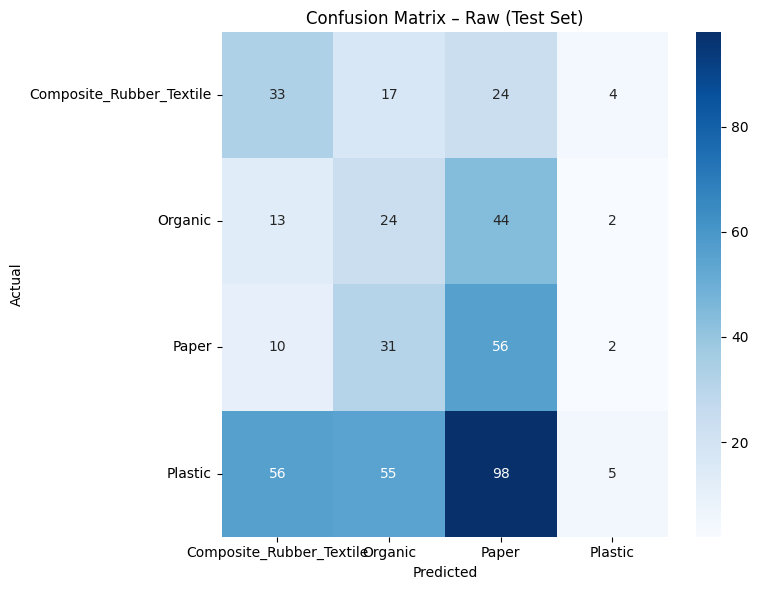

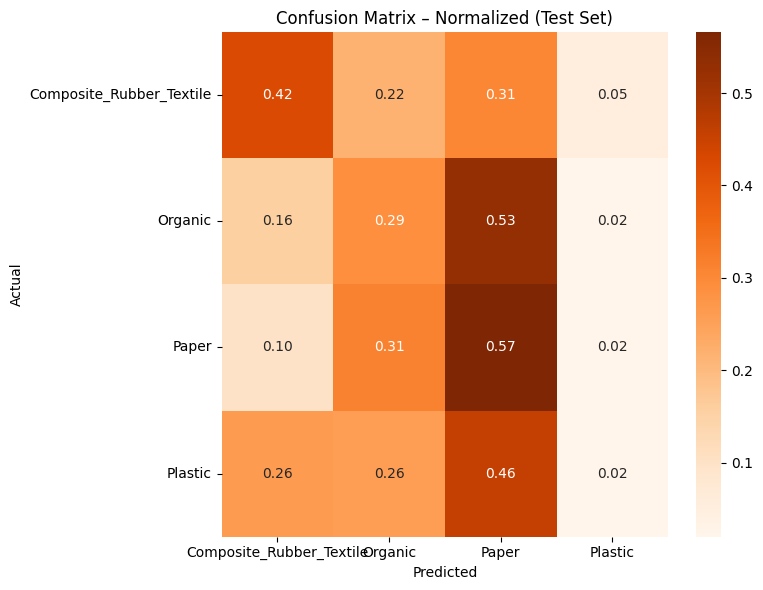

Test ROC AUC (Multiclass OVR): 0.5590


In [16]:
# ============================================================
# STEP 13: Evaluate Best-Performing Model on Held-Out Test Set
# ============================================================
# This step loads the best model configuration (based on validation accuracy)
# and evaluates it on the test dataset using accuracy, precision, recall,
# F1 score, confusion matrix, and ROC AUC. All model parameters used in training
# (architecture, mixup, label smoothing, seed) are printed for traceability.

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score
)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import label_binarize

# 🔎 Show model configuration
print("🧪 STEP 13: Evaluating Best Model Configuration on TEST SET")
print(f"Model Architecture: {best_row['Model']}")
print(f"Mixup Enabled:      {best_row['Mixup']}")
print(f"Label Smoothing:    {best_row['Label Smoothing']}")
print(f"Random Seed:        {best_row['Seed']}")
print(f"Validation Accuracy:{best_row['Val Accuracy']:.4f}")
print(f"Checkpoint File:    {best_row['Checkpoint']}")
print(f"➡️ Dataset Used:      Held-out TEST SET\n")

# 🔧 Load best-performing model
model = create_model(best_model_name, pretrained=False, num_classes=num_classes).to(device)
model.load_state_dict(torch.load(best_checkpoint_path))

def evaluate_model_detailed(model, dataloader, device, label2id, show_roc_auc=True):
    model.eval()
    all_preds, all_probs, all_labels = [], [], []

    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            probs = torch.softmax(outputs, dim=1)
            preds = outputs.argmax(dim=1)

            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)

    id2label = {v: k for k, v in label2id.items()}
    target_names = [id2label[i] for i in sorted(id2label)]

    print("🔍 Classification Report (on Test Set):")
    print(classification_report(all_labels, all_preds, target_names=target_names, digits=4))
    print(f"Test Accuracy:  {accuracy_score(all_labels, all_preds):.4f}")
    print(f"Test Precision: {precision_score(all_labels, all_preds, average='weighted'):.4f}")
    print(f"Test Recall:    {recall_score(all_labels, all_preds, average='weighted'):.4f}")
    print(f"Test F1-Score:  {f1_score(all_labels, all_preds, average='weighted'):.4f}")

    # Confusion Matrix – Raw
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names, yticklabels=target_names)
    plt.title("Confusion Matrix – Raw (Test Set)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    # Confusion Matrix – Normalized
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Oranges',
                xticklabels=target_names, yticklabels=target_names)
    plt.title("Confusion Matrix – Normalized (Test Set)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    # ROC AUC Score
    if show_roc_auc:
        try:
            y_true_bin = label_binarize(all_labels, classes=list(range(len(label2id))))
            auc = roc_auc_score(y_true_bin, all_probs, multi_class='ovr')
            print(f"Test ROC AUC (Multiclass OVR): {auc:.4f}")
        except Exception as e:
            print(f"⚠️ ROC-AUC computation failed: {e}")

# 🧪 Evaluate best model on test data
evaluate_model_detailed(model, test_loader, device, train_ds.label2id)



=== Visualization Legend ===
Left: Original input image.
Right: One of the following, depending on model type:
    - Grad-CAM: Heatmap (red areas are most important for prediction, for CNNs like ResNet/EfficientNet).
    - Feature Map: Heatmap of most activated regions in last block (for ConvNeXt).
    - Attention Map: Patches with highest transformer attention ([CLS] token, for ViT/Swin/DeiT).

Interpret these as: the more the overlay matches the actual object, the better your model is focusing on relevant features.
If overlays are off-object or random, the model may be overfitting or not learning the right things.


[Feature Map] The 'jet' heatmap shows which spatial areas activated most in the last ConvNeXt block for 'Composite_Rubber_Textile'.
Strong activation over the object means the model recognizes relevant features.


[Feature Map] The 'jet' heatmap shows which spatial areas activated most in the last ConvNeXt block for 'Organic'.
Strong activation over the object means the 

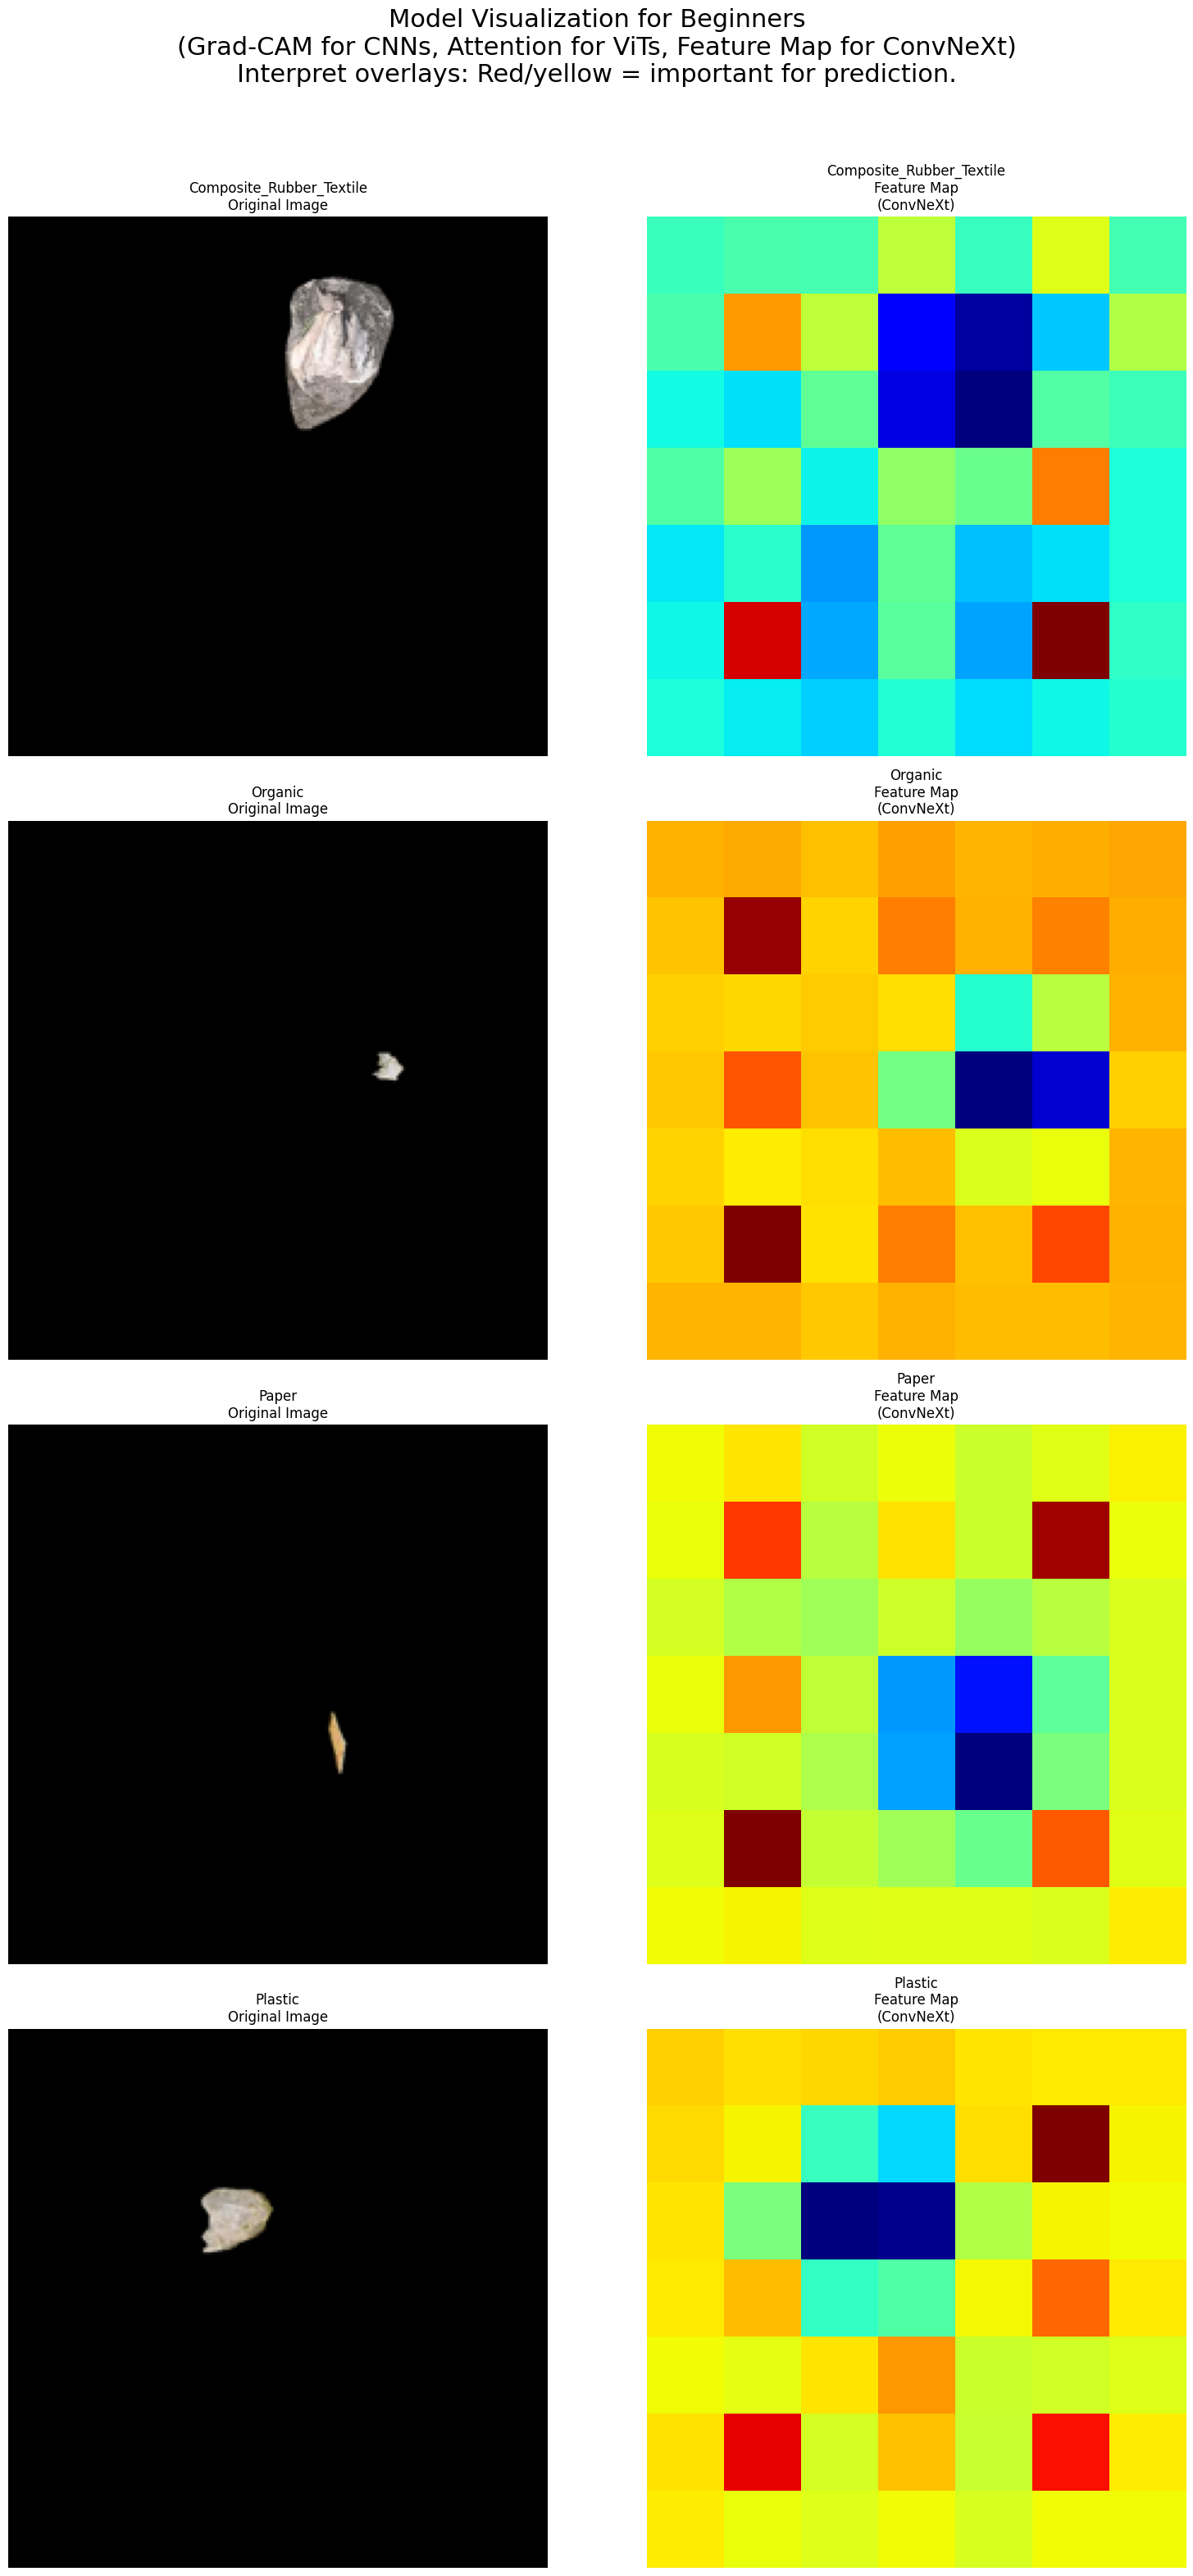

In [22]:
# ===============================================================
# STEP 14: Journal-Ready Visualization (Grad-CAM / Attention / Feature Map)
# With Beginner-Friendly Explanations and Larger Images
# ===============================================================
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
import os, random

# --- Helper: Model type detection ---
def get_model_type(model):
    name = model.__class__.__name__.lower()
    if "convnext" in name:
        return "convnext"
    if "resnet" in name or "efficientnet" in name:
        return "cnn"
    if "vit" in name or "deit" in name or "swin" in name or hasattr(model, "get_last_selfattention"):
        return "transformer"
    return "unknown"

# --- Helper: Grad-CAM for CNNs ---
try:
    from pytorch_grad_cam import GradCAM
    from pytorch_grad_cam.utils.image import show_cam_on_image
    gradcam_available = True
except ImportError:
    gradcam_available = False

def get_gradcam_target_layer(model):
    # For ResNet
    if hasattr(model, "layer4"):
        return [model.layer4[-1]]
    # For EfficientNet
    if hasattr(model, "features"):
        return [model.features[-1]]
    raise ValueError("Could not determine Grad-CAM layer for this model.")

def show_gradcam(model, input_tensor, rgb_image, device, ax, class_name):
    """
    Grad-CAM (Gradient-weighted Class Activation Mapping) highlights the regions in the image
    that most influenced the model's prediction. Bright/red areas mean those regions were
    important for the decision, while blue/dark regions are less important.
    """
    try:
        target_layers = get_gradcam_target_layer(model)
        cam = GradCAM(model=model, target_layers=target_layers, use_cuda=device.type == "cuda")
        grayscale_cam = cam(input_tensor=input_tensor, target_category=None)
        cam_vis = show_cam_on_image(rgb_image, grayscale_cam[0], use_rgb=True)
        ax.imshow(cam_vis)
        ax.set_title(f"{class_name}\nGrad-CAM\n(Red=important)")
        ax.axis("off")
        # Print explanation for beginners
        print(f"\n[Grad-CAM] The heatmap overlay (red/yellow) highlights where the model 'looked' to make its prediction for the class '{class_name}'.")
        print("If the highlighted areas match the object, the model is focusing on the correct features. If not, the model may be confused.\n")
    except Exception as e:
        ax.imshow(np.zeros_like(rgb_image))
        ax.set_title(f"{class_name}\nGrad-CAM failed")
        ax.axis("off")

# --- Helper: Feature Map for ConvNeXt ---
def show_feature_maps(model, input_tensor, ax, class_name):
    """
    Feature Map Visualization shows what patterns the model is extracting in its deepest convolutional layers.
    Bright areas mean strong activation. If these correspond to the object, the model is learning relevant features.
    """
    features = []
    def hook_fn(module, inp, out):
        features.append(out.detach().cpu())
    stages = model.stages if hasattr(model, "stages") else None
    if stages is not None:
        if hasattr(stages[-1], "blocks"):
            last_block = stages[-1].blocks[-1]
        elif hasattr(stages[-1], "block"):
            last_block = stages[-1].block[-1]
        else:
            ax.set_title(f"{class_name}\nFeature map hook failed")
            ax.axis("off")
            return
        h = last_block.register_forward_hook(hook_fn)
        model.eval()
        with torch.no_grad():
            _ = model(input_tensor)
        h.remove()
        fmap = features[0][0]
        fmap_mean = fmap.mean(dim=0).numpy()
        fmap_mean = (fmap_mean - fmap_mean.min()) / (fmap_mean.max() - fmap_mean.min() + 1e-8)
        ax.imshow(fmap_mean, cmap='jet')
        ax.set_title(f"{class_name}\nFeature Map\n(ConvNeXt)")
        ax.axis("off")
        # Print explanation for beginners
        print(f"\n[Feature Map] The 'jet' heatmap shows which spatial areas activated most in the last ConvNeXt block for '{class_name}'.")
        print("Strong activation over the object means the model recognizes relevant features.\n")
    else:
        ax.set_title(f"{class_name}\nNo feature maps")
        ax.axis("off")

# --- Helper: Attention map for ViT/DeiT/Swin ---
def visualize_transformer_attention(model, img_pil, preprocess, device, ax, class_name):
    """
    Attention Map (for Vision Transformers) shows which patches in the image the model 'attended to' when making its prediction.
    Warmer colors (red/yellow) mean higher attention. Good models attend to the main object.
    """
    try:
        img = preprocess(img_pil).unsqueeze(0).to(device)
        model.eval()
        if hasattr(model, "get_last_selfattention"):
            attn = model.get_last_selfattention(img)
            attn = attn[0, :, 0, 1:]
            w_featmap = h_featmap = int(attn.shape[-1] ** 0.5)
            attn = attn.reshape(-1, w_featmap, h_featmap)
            attn_map = attn.mean(0).cpu().numpy()
            attn_map = (attn_map - attn_map.min()) / (attn_map.max() - attn_map.min() + 1e-8)
            attn_map = np.array(Image.fromarray((attn_map * 255).astype(np.uint8)).resize((224, 224)))
            ax.imshow(np.array(img_pil.resize((224, 224))).astype(np.float32) / 255.0)
            ax.imshow(attn_map, cmap='jet', alpha=0.5)
            ax.set_title(f"{class_name}\nViT Attention")
            ax.axis("off")
            # Print explanation for beginners
            print(f"\n[Attention Map] The overlay shows which patches the Vision Transformer attended to for '{class_name}'.")
            print("If the highlighted areas cover the object, the model is focusing on the right regions.\n")
        else:
            ax.imshow(np.array(img_pil.resize((224, 224))).astype(np.float32) / 255.0)
            ax.set_title(f"{class_name}\n(No attention)")
            ax.axis("off")
    except Exception as e:
        ax.imshow(np.zeros((224,224,3)))
        ax.set_title(f"{class_name}\nAttention failed")
        ax.axis("off")

# --- SETUP: model, class_names, TRAIN_DIR, device must be defined above ---

from torchvision import transforms
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

num_classes_to_show = min(4, len(class_names))
selected = []
for class_name in class_names[:num_classes_to_show]:
    class_path = os.path.join(TRAIN_DIR, class_name)
    img_files = [f for f in os.listdir(class_path) if f.lower().endswith(('jpg', 'jpeg', 'png'))]
    if img_files:
        img_path = os.path.join(class_path, random.choice(img_files))
        selected.append((class_name, img_path))

# Increase image size for clearer visualization (16, 8 per image pair)
fig, axes = plt.subplots(len(selected), 2, figsize=(16, 8*len(selected)))
model_type = get_model_type(model)

print("\n=== Visualization Legend ===")
print(
    "Left: Original input image.\n"
    "Right: One of the following, depending on model type:\n"
    "    - Grad-CAM: Heatmap (red areas are most important for prediction, for CNNs like ResNet/EfficientNet).\n"
    "    - Feature Map: Heatmap of most activated regions in last block (for ConvNeXt).\n"
    "    - Attention Map: Patches with highest transformer attention ([CLS] token, for ViT/Swin/DeiT).\n"
)
print("Interpret these as: the more the overlay matches the actual object, the better your model is focusing on relevant features.\n"
      "If overlays are off-object or random, the model may be overfitting or not learning the right things.\n")

for i, (class_name, img_path) in enumerate(selected):
    img_pil = Image.open(img_path).convert("RGB")
    rgb_image = np.array(img_pil.resize((224, 224))).astype(np.float32) / 255.0
    input_tensor = preprocess(img_pil).unsqueeze(0).to(device)

    # Show original image
    axes[i, 0].imshow(rgb_image)
    axes[i, 0].set_title(f"{class_name}\nOriginal Image")
    axes[i, 0].axis("off")

    # Visualization depending on model type, with explanation
    if model_type == "convnext":
        show_feature_maps(model, input_tensor, axes[i, 1], class_name)
    elif model_type == "transformer":
        visualize_transformer_attention(model, img_pil, preprocess, device, axes[i, 1], class_name)
    elif model_type == "cnn" and gradcam_available:
        show_gradcam(model, input_tensor, rgb_image, device, axes[i, 1], class_name)
    else:
        axes[i, 1].imshow(np.zeros_like(rgb_image))
        axes[i, 1].set_title(f"{class_name}\nNo Visualization\nSupported")
        axes[i, 1].axis("off")

plt.suptitle(
    "Model Visualization for Beginners\n"
    "(Grad-CAM for CNNs, Attention for ViTs, Feature Map for ConvNeXt)\n"
    "Interpret overlays: Red/yellow = important for prediction.",
    fontsize=22
)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()